In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.utils.class_weight import compute_class_weight
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
from torch.utils.data import Dataset
from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.transforms import Normalize
from sklearn import preprocessing
import numpy as np

device = 'cuda' if torch.cuda.is_available() else 'cpu'

C:\Users\SystemX\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class Encoder(nn.Module):
    def __init__(self, latent_dims):
        super(Encoder, self).__init__()
        self.linear1 = nn.Linear(41, 20)
        self.linear2 = nn.Linear(20, latent_dims)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        return F.selu(self.linear2(F.selu(self.linear1(x))))


class Decoder(nn.Module):
    def __init__(self, latent_dims):
        super(Decoder, self).__init__()
        self.linear1 = nn.Linear(latent_dims, 20)
        self.linear2 = nn.Linear(20, 41)

    def forward(self, z):
        z = self.linear2(F.selu(self.linear1(z)))
        return z


class Autoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        z = self.encoder(x)
        z = self.decoder(z)
        return z
class EmbDataset(Dataset):
    def __init__(self, rows, targets):
        self.rows = torch.from_numpy(rows)
        self.targets = torch.from_numpy(targets)
    def __len__(self):
        return len(self.rows)
    def __getitem__(self, idx):
        return self.rows[idx], self.targets[idx]
H = {"train_loss": [], "test_loss": []}
def train(autoencoder, data, val_loader, epochs=1):
    best_loss = float('inf')
    opt = torch.optim.Adam(autoencoder.parameters(), lr=10e-3)
    totalTrainLoss = 0
    loss_cos = nn.CosineEmbeddingLoss()
    loss_dist = nn.MSELoss()
    
    for epoch in tqdm(range(epochs)):
        autoencoder.train()
        totalTrainLoss = 0
        for (i, (x, y)) in enumerate(data):
            x = x.to(device) # GPU
            opt.zero_grad()
            x_hat = autoencoder(x)
            loss = loss_dist(x, x_hat) + loss_cos(x, x_hat, torch.ones(len(x)).to(device))
            loss.backward()
            opt.step()

            totalTrainLoss += loss
        totalTestLoss=0 

        with torch.no_grad():
            autoencoder.eval()
            for (x, y) in val_loader:
                (x, y) = (x.to('cuda:0'), y.to('cuda:0'))
                pred = autoencoder(x)
                totalTestLoss += loss_dist(x, pred) + loss_cos(x, pred, torch.ones(len(x)).to(device))
                
        avgTrainLoss = totalTrainLoss / trainSteps
        avgTestLoss = totalTestLoss / testSteps

        if best_loss > avgTestLoss:
            torch.save(autoencoder.state_dict(), 'code_emb_2.pt')
            best_loss = avgTestLoss
            
        H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
        H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
        print("[INFO] EPOCH: {}/{}".format(epoch + 1, 100))
        print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
        
    return autoencoder

In [3]:
latent_dims = 2 # p
autoencoder = Autoencoder(latent_dims).to(device) # GPU
autoencoder.load_state_dict(torch.load('code_emb_2.pt'))

<All keys matched successfully>

In [108]:
df = pd.read_csv('test.csv')
# df['cum_sum'] = df.sort_values('quarter').groupby('client_id')['churn'].cumsum().shift(1).fillna(0) 
# df["not_churn"] = df["churn"].apply(lambda x: 1 if x == 0 else 0)
# df['cum_cnt'] = df.sort_values('quarter').groupby('client_id')['not_churn'].cumsum().shift(1).fillna(0)
# df.drop(columns='not_churn', inplace=True)
df_contribs = pd.read_csv('cntrbtrs.csv', sep=';')
df.fillna(0, inplace=True)
print(df.shape)

result = pd.merge(df, df_contribs.drop_duplicates('npo_accnt_id'), left_on='npo_account_id', right_on='npo_accnt_id', how='left')
print(result.shape)
result['accnt_pnsn_schm'] = result['accnt_pnsn_schm'].astype('str')
result.drop(columns=["client_id", "npo_account_id", "npo_accnt_id"], axis=1, inplace=True)

last_q = '2022Q1'

result['balance'] = result['balance'].apply(lambda x: x if x > 0 else 1)
result['pmnts_nmbr_per_qrtr'] = result['pmnts_nmbr_per_qrtr'].apply(lambda x: x if x > 0 else 1)
print(df.shape)
# result = result[result['balance'] > 0]

result['pml_check'] = (result['lst_pmnt_date_per_qrtr'] != 0).astype('bool')
result['q_n'] = result['quarter'].apply(lambda x: x[-1]).astype('int')
result['frst_pmnt_date'] = result['frst_pmnt_date'].astype('category')
result['lst_pmnt_date_per_qrtr'] = result['lst_pmnt_date_per_qrtr'].astype('category')
result['region'] = result['region'].astype('category')
result['accnt_pnsn_schm'] = result['accnt_pnsn_schm'].astype('category')
result['rfm'] = np.log10(result['balance'] + 1) * result['pmnts_nmbr_per_qrtr'] / (result['lst_pmnt_rcnc_d'] + 1)


(633434, 41)
(633434, 44)
(633434, 41)


In [101]:
df

,slctn_nmbr,client_id,npo_account_id,npo_accnts_nmbr,pmnts_type,year,quarter,gender,age,clnt_cprtn_time_d,...,email,lk,assignee_npo,assignee_ops,postal_code,region,citizen,fact_addrss,appl_mrkr,evry_qrtr_pmnt
0,0,0x589BC912CB844D468212ADD42EAE4151,0xAA9E8DDF1310724995598EA2B42D7D87,2,1,2017,2017Q2,1,54,6595,...,0,1,-1,-1,398046.0,ЛИПЕЦКАЯ ОБЛ,1,1,0,1
1,2,0xCCF22420C90AE4459A25781A9A30F445,0x3B9B09857D152F468A42C5DEE6D723F7,1,3,2021,2021Q4,1,75,7078,...,-1,-1,-1,-1,0.0,МОСКВА Г,1,1,0,0
2,3,0x943D2C768A4FB38311E6605EEA2B9E4A,0xA7F12C768A4FB38311E835E4A7632E00,1,2,2015,2015Q3,1,35,1675,...,0,-1,-1,-1,666211.0,ИРКУТСКАЯ ОБЛ,-1,1,0,0
3,2,0x99E64FD29CC3B04189C5C9EBEAF6F9A4,0xBFE4BDFBE0E037478C29BA4F38121B15,1,1,2015,2015Q3,1,50,5180,...,-1,-1,-1,-1,162610.0,ВОЛОГОДСКАЯ ОБЛ,1,1,0,1
4,0,0x654EEEBA731C4A4881816631229C5B65,0x4B5C7804E403C842B4ECBF69BC3EDD7C,2,1,2011,2011Q3,-1,46,296,...,0,-1,-1,-1,427111.0,УДМУРТСКАЯ РЕСП,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633429,0,0x166618F0B41D4744B2B1AF9983F41ED7,0x3086DA482BB98F4CB01FBFBCF699B603,1,3,2022,2022Q3,-1,55,2510,...,0,1,-1,-1,352800.0,КРАСНОДАРСКИЙ КРАЙ,1,1,0,1
633430,0,0xB9C2A95250AE0846A0AAA02B8EC5D717,0x44CA6910C3C5904BA87936C53926BABC,1,3,2020,2020Q2,1,52,1580,...,0,-1,-1,-1,614016.0,ПЕРМСКИЙ КРАЙ,1,1,0,1
633431,0,0xA629005056964A2C11ED63E9F4E5512F,0xA62A005056964A2C11ED7C7CECEF8EC0,1,3,2022,2022Q4,1,49,382,...,0,-1,-1,-1,628331.0,ХАНТЫ-МАНСИЙСКИЙ АВТОНОМНЫЙ ОКРУГ - ЮГРА АО,-1,-1,0,1
633432,0,0x4D4971EE22A08249BE6F688738DB4D97,0xABCE12A6F911374E96C7CB080F45C900,1,3,2021,2021Q2,1,33,890,...,0,-1,-1,-1,665824.0,ИРКУТСКАЯ ОБЛ,1,1,0,1


In [102]:
result

,slctn_nmbr_x,client_id,npo_account_id,npo_accnts_nmbr,pmnts_type,year,quarter,gender,age,clnt_cprtn_time_d,...,citizen,fact_addrss,appl_mrkr,evry_qrtr_pmnt,slctn_nmbr_y,npo_accnt_id,accnt_pnsn_schm,pml_check,q_n,rfm
0,0,0x589BC912CB844D468212ADD42EAE4151,0xAA9E8DDF1310724995598EA2B42D7D87,2,1,2017,2017Q2,1,54,6595,...,1,1,0,1,0,0xAA9E8DDF1310724995598EA2B42D7D87,354.0,True,2,0.531304
1,2,0xCCF22420C90AE4459A25781A9A30F445,0x3B9B09857D152F468A42C5DEE6D723F7,1,3,2021,2021Q4,1,75,7078,...,1,1,0,0,2,0x3B9B09857D152F468A42C5DEE6D723F7,8.0,False,4,0.001062
2,3,0x943D2C768A4FB38311E6605EEA2B9E4A,0xA7F12C768A4FB38311E835E4A7632E00,1,2,2015,2015Q3,1,35,1675,...,-1,1,0,0,3,0xA7F12C768A4FB38311E835E4A7632E00,455.0,True,3,0.443252
3,2,0x99E64FD29CC3B04189C5C9EBEAF6F9A4,0xBFE4BDFBE0E037478C29BA4F38121B15,1,1,2015,2015Q3,1,50,5180,...,1,1,0,1,2,0xBFE4BDFBE0E037478C29BA4F38121B15,0.0,True,3,0.455225
4,0,0x654EEEBA731C4A4881816631229C5B65,0x4B5C7804E403C842B4ECBF69BC3EDD7C,2,1,2011,2011Q3,-1,46,296,...,1,1,0,1,0,0x4B5C7804E403C842B4ECBF69BC3EDD7C,351.0,True,3,0.373880
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
633432,0,0x166618F0B41D4744B2B1AF9983F41ED7,0x3086DA482BB98F4CB01FBFBCF699B603,1,3,2022,2022Q3,-1,55,2510,...,1,1,0,1,0,0x3086DA482BB98F4CB01FBFBCF699B603,351.0,True,3,0.188932
633433,0,0xB9C2A95250AE0846A0AAA02B8EC5D717,0x44CA6910C3C5904BA87936C53926BABC,1,3,2020,2020Q2,1,52,1580,...,1,1,0,1,0,0x44CA6910C3C5904BA87936C53926BABC,351.0,True,2,0.558422
633434,0,0xA629005056964A2C11ED63E9F4E5512F,0xA62A005056964A2C11ED7C7CECEF8EC0,1,3,2022,2022Q4,1,49,382,...,-1,-1,0,1,0,0xA62A005056964A2C11ED7C7CECEF8EC0,361.0,True,4,0.458620
633435,0,0x4D4971EE22A08249BE6F688738DB4D97,0xABCE12A6F911374E96C7CB080F45C900,1,3,2021,2021Q2,1,33,890,...,1,1,0,1,0,0xABCE12A6F911374E96C7CB080F45C900,351.0,True,2,0.586502


In [96]:
df.iloc[i,:].npo_account_id

'0x3B9B09857D152F468A42C5DEE6D723F7'

In [103]:
for i in range(result.shape[0]):
    if result.iloc[i,:].npo_account_id != df.iloc[i,:].npo_account_id:
        print("miss" + str(i))

miss79691
miss79692
miss79693
miss79694
miss79695
miss79696
miss79697
miss79698
miss79699
miss79700
miss79701
miss79702
miss79703
miss79704
miss79705
miss79706
miss79707
miss79708
miss79709
miss79710
miss79711
miss79712
miss79713
miss79714
miss79715
miss79716
miss79717
miss79718
miss79719
miss79720
miss79721
miss79722
miss79723
miss79724
miss79725
miss79726
miss79727
miss79728
miss79729
miss79730
miss79731
miss79732
miss79733
miss79734
miss79735
miss79736
miss79737
miss79738
miss79739
miss79740
miss79741
miss79742
miss79743
miss79744
miss79745
miss79746
miss79747
miss79748
miss79749
miss79750
miss79751
miss79752
miss79753
miss79754
miss79755
miss79756
miss79757
miss79758
miss79759
miss79760
miss79761
miss79762
miss79763
miss79764
miss79765
miss79766
miss79767
miss79768
miss79769
miss79770
miss79771
miss79772
miss79773
miss79774
miss79775
miss79776
miss79777
miss79778
miss79779
miss79780
miss79781
miss79782
miss79783
miss79784
miss79785
miss79786
miss79787
miss79788
miss79789
miss79790


KeyboardInterrupt: 

In [70]:
result.shape

(633437, 44)

In [109]:
result_test = result
# result_test = result[result['quarter'] > last_q]
# result_train = result[result['quarter'] <= last_q]
result_test['quarter'] = result['quarter'].astype('category')
# result_train['quarter'] = result['quarter'].astype('category')
# result_test = result_test.drop(columns='quarter')
# result_train = result_train.drop(columns='quarter')

# result_test.drop(columns=['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm'], axis=1, inplace=True)
# result_train.drop(columns=['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm'], axis=1, inplace=True)

# result_train, result_val = np.split(result_train, [int(0.7*len(result_train))])
# X = result_train.drop('churn', axis=1)
# y = result_train['churn']
# X_validation, y_validation = result_val.drop('churn', axis=1), result_val['churn']

X_test = result_test    
# X_test = result_test.drop('churn', axis=1)
# y_test = result_test['churn']

classes = np.unique(y)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y)
class_weights = dict(zip(classes, weights))

In [110]:
# X_cluster = X[list(set(X.columns) - set(['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm']))]
# normalizer = preprocessing.Normalizer().fit(X_cluster) 
# X_auto = normalizer.transform(X_cluster)
# model = autoencoder.encoder.to('cpu')
# emb = model(torch.tensor(X_auto, dtype=torch.float32))
# X2 = X.join(pd.DataFrame(emb.detach().numpy()))
X2 = X

# X_test['cum_sum']=0
# X_test['cum_cnt']=0

# X_cluster = X_test[list(set(X_test.columns) - set(['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm']))]
# X_cluster.join
# normalizer = preprocessing.Normalizer().fit(X_cluster) 
# X_auto = normalizer.transform(X_cluster)
# model = autoencoder.encoder.to('cpu')
# emb = model(torch.tensor(X_auto, dtype=torch.float32))
# X_test2 = X_test.join(pd.DataFrame(emb.detach().numpy()))
X_test2 = X_test
# X_test2.drop(columns=['accnt_pnsn_schm', 'cum_sum', 'cum_cnt'], axis=1, inplace=True)


# X_cluster = X_validation[list(set(X_validation.columns) - set(['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm']))]
# normalizer = preprocessing.Normalizer().fit(X_cluster) 
# X_auto = normalizer.transform(X_cluster)
# model = autoencoder.encoder.to('cpu')
# emb = model(torch.tensor(X_auto, dtype=torch.float32))
# X_validation2 = X_validation.join(pd.DataFrame(emb.detach().numpy()))
X_validation2 = X_validation

In [ ]:
# X_cluster = X[list(set(X.columns) - set(['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm']))]
# normalizer = preprocessing.Normalizer().fit(X_cluster) 
# X_auto = normalizer.transform(X_cluster)
# model = autoencoder.encoder.to('cpu')
# emb = model(torch.tensor(X_auto, dtype=torch.float32))
# X2 = pd.concat([X, pd.DataFrame(emb.detach().numpy(), index=X.index)], axis=1)
# pd.DataFrame(emb.detach().numpy()).shape, X.shape, X.join(pd.DataFrame(emb.detach().numpy())).shape

In [7]:
model_cat = CatBoostClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    depth=5,
    # grow_policy='Lossguide',
    task_type='GPU',
    # l2_leaf_reg=2
    class_weights=class_weights
)

model_cat.fit(X2, y, 
          cat_features=['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm'],
          eval_set=(X_validation2, y_validation),
          verbose=10, 
         )

0:	learn: 0.5565795	test: 0.5766479	best: 0.5766479 (0)	total: 1.08s	remaining: 17m 56s
10:	learn: 0.2638087	test: 0.3225396	best: 0.3225396 (10)	total: 2.15s	remaining: 3m 13s
20:	learn: 0.2165425	test: 0.2728422	best: 0.2728422 (20)	total: 3.87s	remaining: 3m
30:	learn: 0.1972931	test: 0.2516280	best: 0.2516280 (30)	total: 10.2s	remaining: 5m 18s
40:	learn: 0.1860549	test: 0.2404326	best: 0.2404326 (40)	total: 11.4s	remaining: 4m 26s
50:	learn: 0.1765736	test: 0.2318063	best: 0.2318063 (50)	total: 12.5s	remaining: 3m 52s
60:	learn: 0.1696060	test: 0.2233400	best: 0.2233400 (60)	total: 13.6s	remaining: 3m 28s
70:	learn: 0.1642970	test: 0.2181386	best: 0.2181386 (70)	total: 14.6s	remaining: 3m 11s
80:	learn: 0.1603935	test: 0.2149754	best: 0.2149754 (80)	total: 15.7s	remaining: 2m 58s
90:	learn: 0.1565662	test: 0.2108689	best: 0.2108689 (90)	total: 16.6s	remaining: 2m 46s
100:	learn: 0.1531985	test: 0.2080194	best: 0.2080194 (100)	total: 17.5s	remaining: 2m 36s
110:	learn: 0.1500430	te

In [8]:
model_cat2 = CatBoostClassifier(
    iterations=2000, 
    learning_rate=0.1, 
    depth=4,
    # grow_policy='Lossguide',
    task_type='GPU',
    # l2_leaf_reg=2
    # class_weights=class_weights
)

model_cat2.fit(X2, y, 
          cat_features=['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm'],
          eval_set=(X_validation2, y_validation),
          verbose=10, 
         )

0:	learn: 0.4580198	test: 0.4686999	best: 0.4686999 (0)	total: 159ms	remaining: 5m 17s
10:	learn: 0.0400868	test: 0.0831048	best: 0.0831048 (10)	total: 1s	remaining: 3m 1s
20:	learn: 0.0294315	test: 0.0767783	best: 0.0767783 (20)	total: 1.89s	remaining: 2m 58s
30:	learn: 0.0267645	test: 0.0742875	best: 0.0742875 (30)	total: 2.74s	remaining: 2m 54s
40:	learn: 0.0249753	test: 0.0706657	best: 0.0706657 (40)	total: 3.5s	remaining: 2m 47s
50:	learn: 0.0236388	test: 0.0677738	best: 0.0677738 (50)	total: 4.26s	remaining: 2m 42s
60:	learn: 0.0226065	test: 0.0647689	best: 0.0647689 (60)	total: 5.05s	remaining: 2m 40s
70:	learn: 0.0218962	test: 0.0622274	best: 0.0622274 (70)	total: 5.82s	remaining: 2m 38s
80:	learn: 0.0213307	test: 0.0610248	best: 0.0610248 (80)	total: 6.63s	remaining: 2m 37s
90:	learn: 0.0209292	test: 0.0598648	best: 0.0598648 (90)	total: 7.42s	remaining: 2m 35s
100:	learn: 0.0205654	test: 0.0591173	best: 0.0591173 (100)	total: 8.19s	remaining: 2m 33s
110:	learn: 0.0200092	test

In [9]:
model_lgbm = LGBMClassifier()
model_lgbm.fit(X2, y)

[LightGBM] [Warning] Categorical features with more bins than the configured maximum bin number found.
[LightGBM] [Warning] For categorical features, max_bin and max_bin_by_feature may be ignored with a large number of categories.
[LightGBM] [Info] Number of positive: 23962, number of negative: 2379621
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.112491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 10306
[LightGBM] [Info] Number of data points in the train set: 2403583, number of used features: 44
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.009969 -> initscore=-4.598227
[LightGBM] [Info] Start training from score -4.598227


LGBMClassifier()

In [10]:
model_xgb = XGBClassifier(
    iterations=1000, 
    learning_rate=0.1, 
    depth=3,
    enable_categorical=False,
    task_type='GPU'
)

model_xgb.fit(X2.drop(columns=['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm']), y)

C:\Users\SystemX\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [09:29:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\learner.cc:742: 
Parameters: { "depth", "iterations", "task_type" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, depth=3, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, iterations=1000, learning_rate=0.1,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None, ...)

In [11]:
preds_cat = model_cat.predict(X_test2)
print(classification_report(y_test, preds_cat))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77    154391
           1       0.02      1.00      0.04      1353

    accuracy                           0.63    155744
   macro avg       0.51      0.81      0.41    155744
weighted avg       0.99      0.63      0.76    155744


In [116]:
# save model_lgbm
import pickle
with open('res_model_cat2.pkl', 'wb') as f:
    pickle.dump(model_cat2, f)
with open('res_model_cat.pkl', 'wb') as f:
    pickle.dump(model_cat, f)
with open('res_model_lgbm.pkl', 'wb') as f:
    pickle.dump(model_lgbm, f)
with open('res_preds_model_xgb.pkl', 'wb') as f:
    pickle.dump(model_xgb, f)

In [13]:
preds_lgbm = model_lgbm.predict(X_test2)
print(classification_report(y_test, preds_lgbm))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    154391
           1       0.66      0.81      0.73      1353

    accuracy                           0.99    155744
   macro avg       0.83      0.90      0.86    155744
weighted avg       1.00      0.99      1.00    155744


In [14]:
preds_xgb = model_xgb.predict(X_test2.drop(columns=['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm']))
print(classification_report(y_test, preds_xgb))

              precision    recall  f1-score   support

           0       1.00      0.93      0.96    154391
           1       0.10      0.84      0.18      1353

    accuracy                           0.93    155744
   macro avg       0.55      0.88      0.57    155744
weighted avg       0.99      0.93      0.96    155744


In [17]:
preds_cat_proba = model_cat.predict_proba(X_test2)[:, 1]
preds_cat_proba2 = model_cat2.predict_proba(X_test2)[:, 1]
preds_lgbm_proba = model_lgbm.predict_proba(X_test2)[:, 1]
preds_xgb_proba = model_xgb.predict_proba(X_test2.drop(columns=['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm']))[:, 1]
print(classification_report(y_test, (((preds_cat_proba + preds_cat_proba2 + preds_lgbm_proba + preds_xgb_proba) / 4) > .51).astype('int')))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    154391
           1       0.80      0.85      0.83      1353

    accuracy                           1.00    155744
   macro avg       0.90      0.93      0.91    155744
weighted avg       1.00      1.00      1.00    155744


In [16]:
X_test2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 155744 entries, 164 to 3589942
Data columns (total 44 columns):
 #   Column                  Non-Null Count   Dtype   
---  ------                  --------------   -----   
 0   slctn_nmbr_x            155744 non-null  int64   
 1   npo_accnts_nmbr         155744 non-null  int64   
 2   pmnts_type              155744 non-null  int64   
 3   year                    155744 non-null  int64   
 4   quarter                 155744 non-null  category
 5   gender                  155744 non-null  int64   
 6   age                     155744 non-null  int64   
 7   clnt_cprtn_time_d       155744 non-null  int64   
 8   actv_prd_d              155744 non-null  int64   
 9   lst_pmnt_rcnc_d         155744 non-null  int64   
 10  balance                 155744 non-null  float64 
 11  oprtn_sum_per_qrtr      155744 non-null  float64 
 12  oprtn_sum_per_year      155744 non-null  float64 
 13  frst_pmnt_date          155744 non-null  category
 14  lst_pm

In [111]:

# X_test2.fillna
preds_cat_proba = model_cat.predict_proba(X_test2)[:, 1]
preds_cat_proba2 = model_cat2.predict_proba(X_test2)[:, 1]
preds_lgbm_proba = model_lgbm.predict_proba(X_test2)[:, 1]
preds_xgb_proba = model_xgb.predict_proba(X_test2.drop(columns=['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm']))[:, 1]

len((((preds_cat_proba + preds_cat_proba2 + preds_lgbm_proba + preds_xgb_proba) / 4) > .51).astype('int'))

633434

In [57]:
df.shape

(633434, 41)

In [114]:
X_test2.shape

(633434, 44)

In [115]:
ans = df[["npo_account_id", "quarter"]].join(pd.DataFrame((((preds_cat_proba + preds_cat_proba2 + preds_lgbm_proba + preds_xgb_proba) / 4) > .51).astype('int'), columns=['churn']))
ans.to_csv('res3.csv', index=False)

C:\Users\SystemX\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SystemX\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SystemX\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.p

0.83


C:\Users\SystemX\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SystemX\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\SystemX\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.p

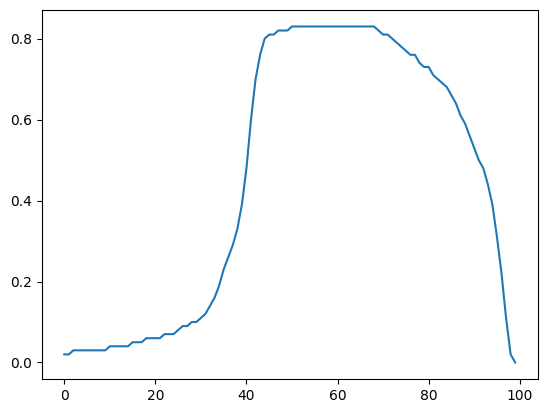

In [18]:
results = []
max_res = 0
for i in range(100):
    res = float(classification_report(y_test, (((preds_cat_proba + preds_cat_proba2 + preds_lgbm_proba + preds_xgb_proba) / 4) > float(i) / 100).astype('int')).split('\n')[3].split()[3])
    if res > max_res:
        max_res = res
    results.append(res)
plt.plot(results)
print(max_res)

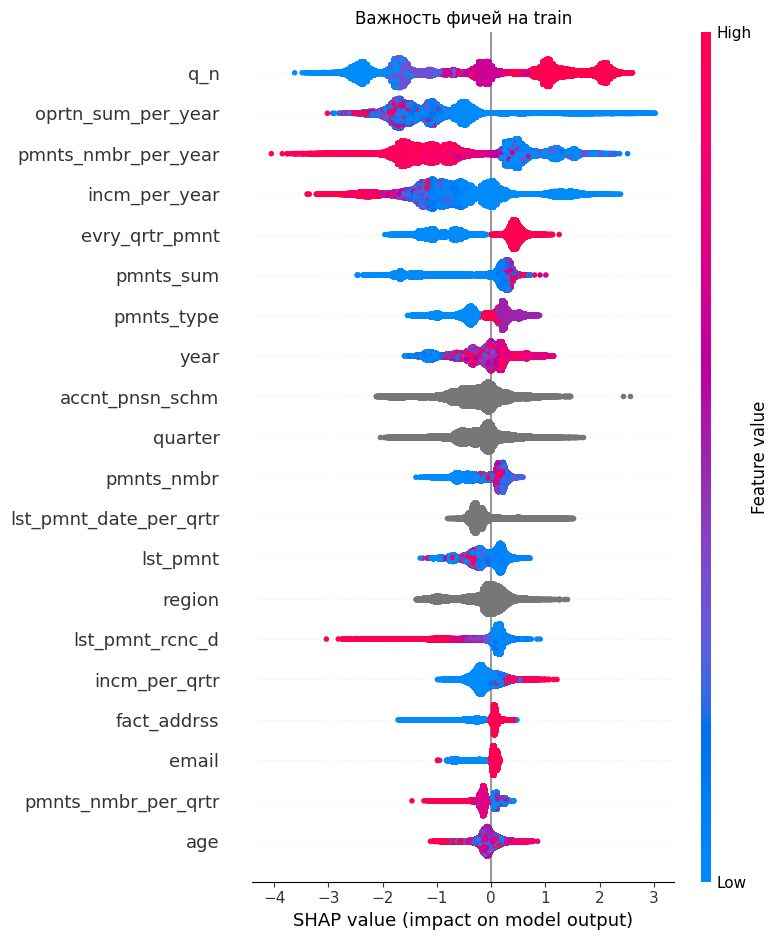

In [17]:
import shap
from catboost import Pool

# сэмплируем для shap_values
X_train_subs, _, y_train_subs, __ = train_test_split(X2, y,
                                                     test_size=0.9,
                                                     random_state=13)
# считаем shap_values
shap_values = model_cat.get_feature_importance(Pool(X_train_subs, y_train_subs,
                                                   cat_features=['quarter', 'frst_pmnt_date', 'lst_pmnt_date_per_qrtr', 'region', 'accnt_pnsn_schm']), type='ShapValues')

expected_value = shap_values[0, -1]
shap_values = shap_values[:, :-1]

plt.title("Важность фичей на train")

shap.summary_plot(
    shap_values,
    X_train_subs
)